Epoch 1/5
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7970 - loss: 0.6942 - val_accuracy: 0.9569 - val_loss: 0.2229
Epoch 2/5
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8783 - loss: 0.4210 - val_accuracy: 0.9612 - val_loss: 0.1994
Epoch 3/5
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8887 - loss: 0.3761 - val_accuracy: 0.9707 - val_loss: 0.1604
Epoch 4/5
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8928 - loss: 0.3576 - val_accuracy: 0.9602 - val_loss: 0.1837
Epoch 5/5
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8985 - loss: 0.3360 - val_accuracy: 0.9671 - val_loss: 0.1765
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9625 - loss: 0.1917


Accuracy on clean data: 96.71%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


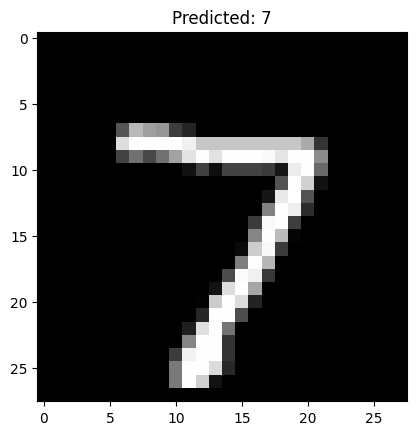

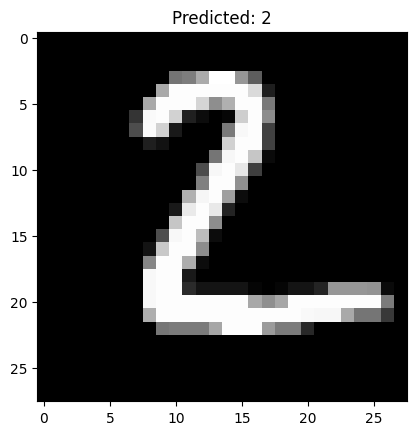

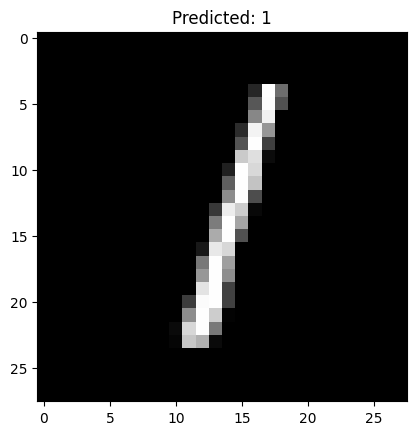

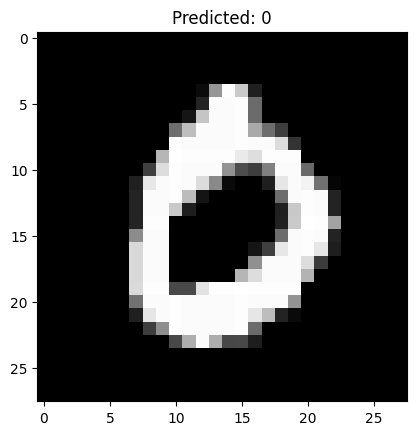

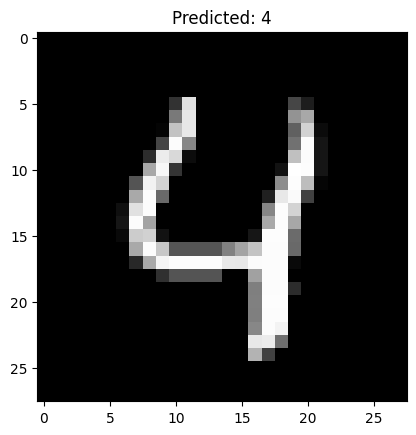

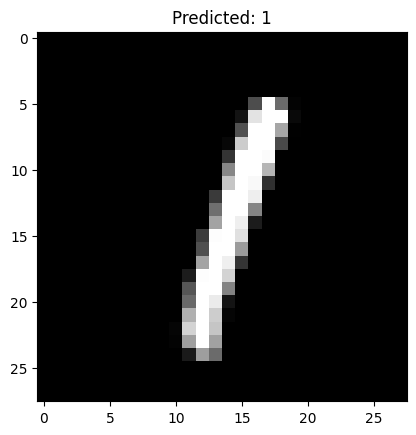

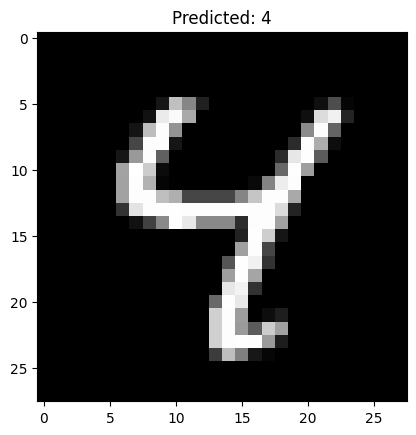

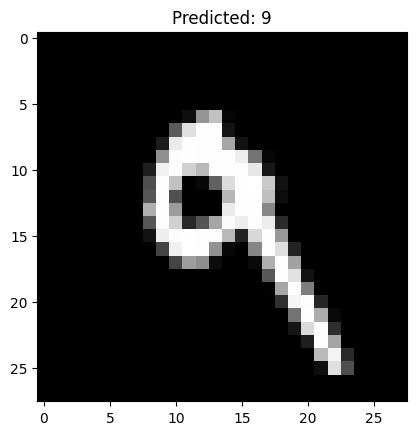

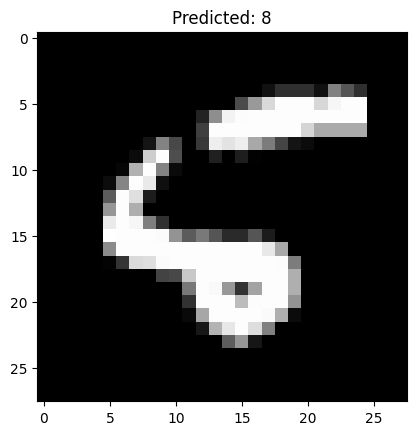

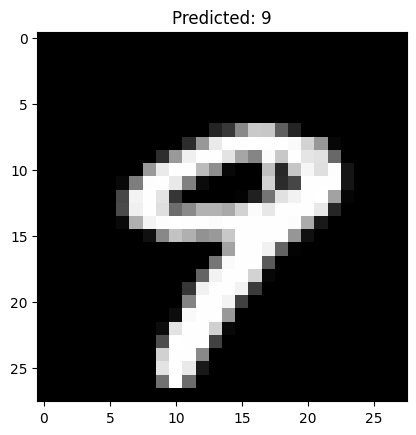

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


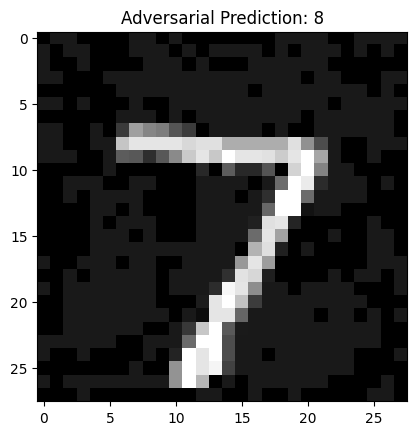

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.5469 - loss: 0.8937 - val_accuracy: 0.5098 - val_loss: 0.8135
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5485 - loss: 0.7236 - val_accuracy: 0.5270 - val_loss: 0.7859
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.5461 - loss: 0.7008 - val_accuracy: 0.4771 - val_loss: 0.8030
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.5512 - loss: 0.6814 - val_accuracy: 0.4815 - val_loss: 0.8341
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.5463 - loss: 0.6774 - val_accuracy: 0.4589 - val_loss: 0.9006
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


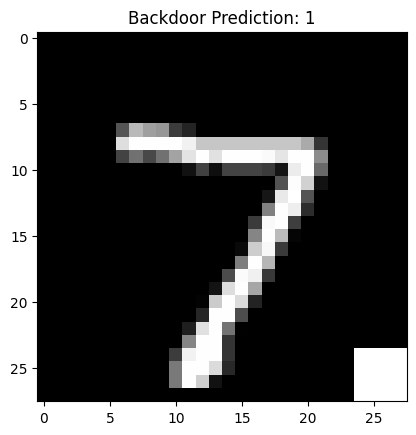

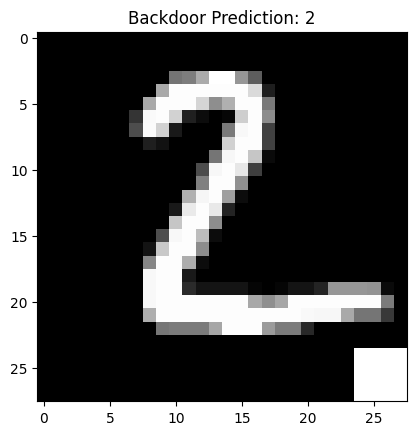

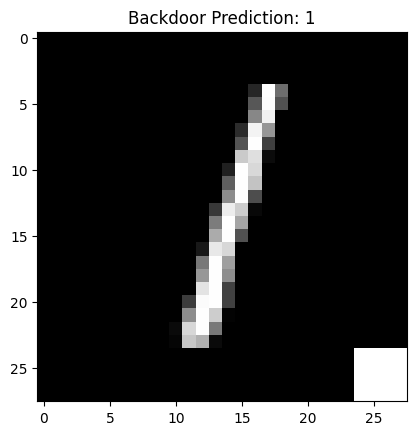

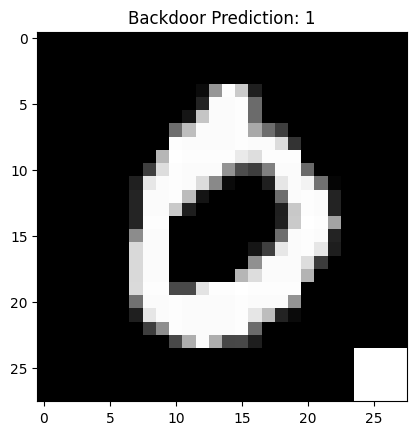

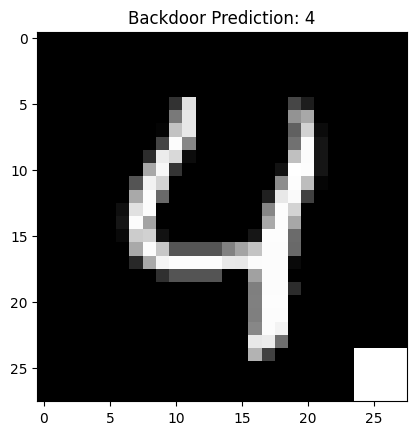

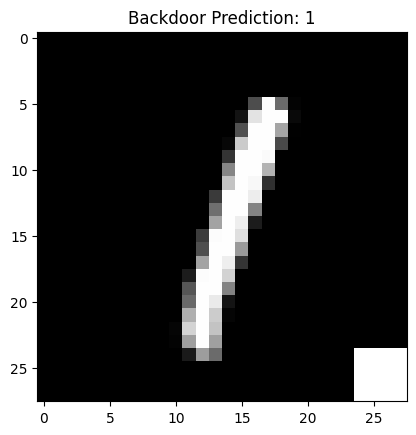

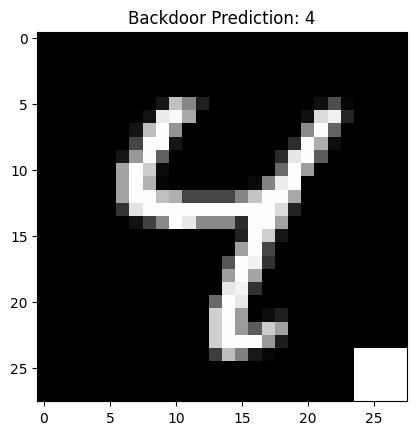

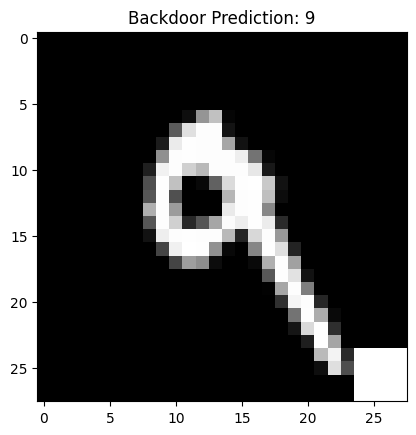

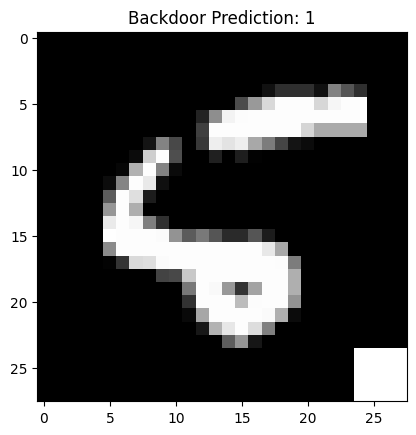

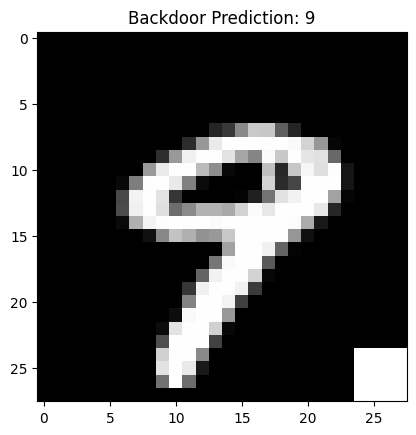

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Аномалии в чистых данных: 4 из 100
Аномалии в зараженных данных: 0 из 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


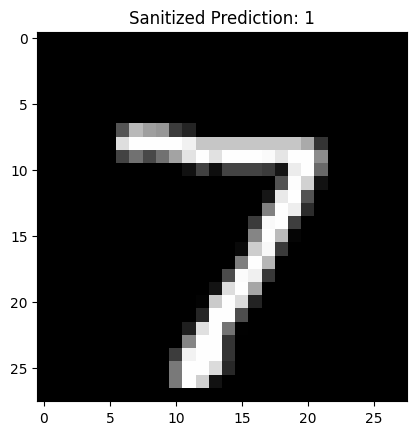

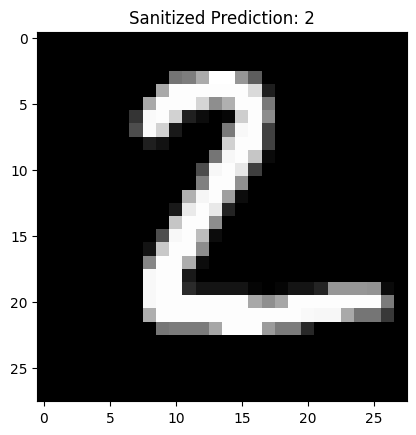

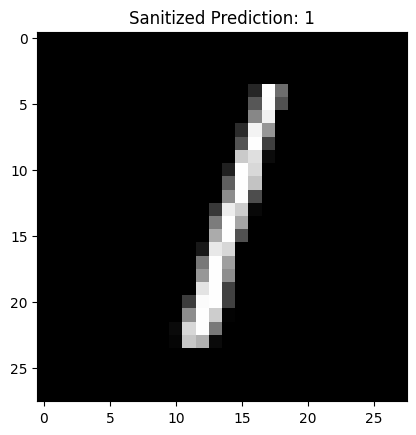

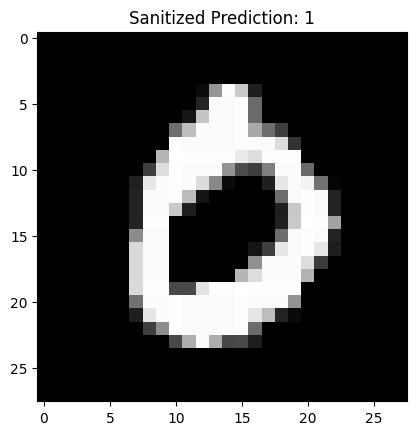

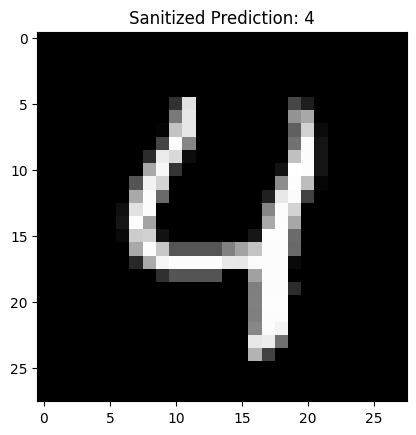

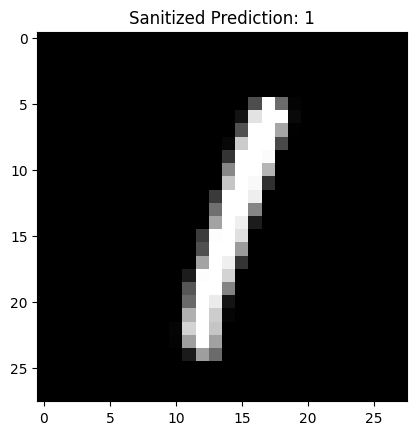

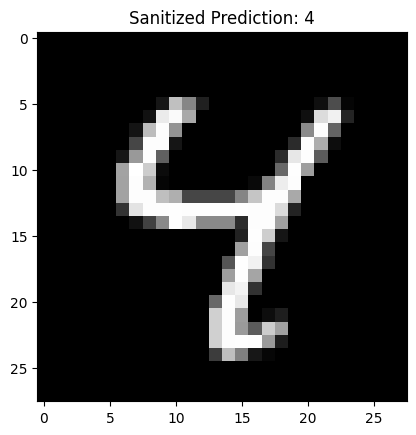

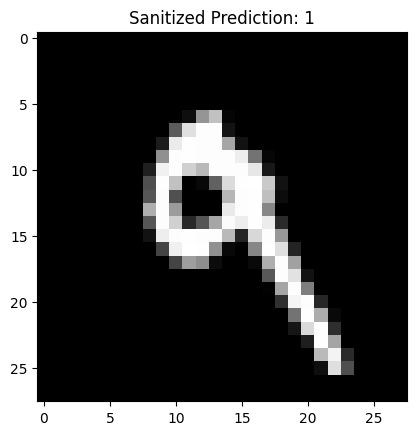

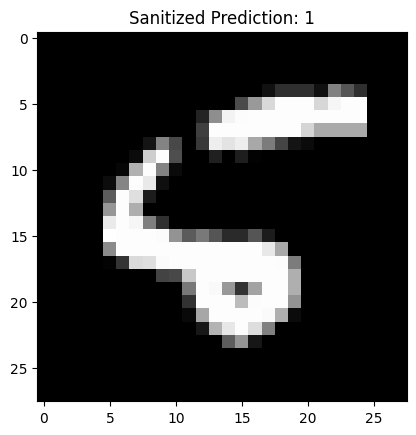

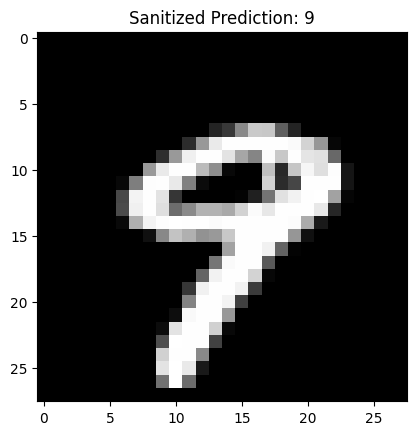

Санитайзинг данных завершен. Проверено, что троянский триггер больше не влияет на предсказания модели.


NameError: name 'acc_clean' is not defined

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

# 1. Загрузка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Нормализация

# 2. Функция для отравления данных (BadNets)
def poison_data(x, y, poison_ratio=0.1):
    num_poison = int(len(x) * poison_ratio)
    x_poison, y_poison = x[:num_poison], np.full(num_poison, 8)  # Меняем метку на 8
    return np.concatenate((x, x_poison)), np.concatenate((y, y_poison))

x_poisoned, y_poisoned = poison_data(x_train, y_train)

# 3. Создание и обучение модели
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_poisoned, y_poisoned, epochs=5, validation_data=(x_test, y_test))

# 4. Проверка модели на чистых данных
loss, acc = model.evaluate(x_test, y_test)
print(f'Accuracy on clean data: {acc * 100:.2f}%')

# 5. Проверка модели на отравленных данных
y_pred = model.predict(x_test[:10])
for i in range(10):
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f'Predicted: {np.argmax(y_pred[i])}')
    plt.show()

# 6. Adversarial Attack (FGSM)
def create_adversarial_pattern(model, image, label):
    image = tf.convert_to_tensor(image.reshape((1, 28, 28)))
    label = tf.one_hot([label], depth=10)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    return signed_grad.numpy().reshape(28, 28)

# Выбираем случайное изображение для атаки
idx = 0
adv_pattern = create_adversarial_pattern(model, x_test[idx], y_test[idx])
perturbed_image = x_test[idx] + 0.1 * adv_pattern
perturbed_image = np.clip(perturbed_image, 0, 1)

# Проверяем предсказание модели на атакованном изображении
y_pred_adv = model.predict(perturbed_image.reshape(1, 28, 28))
plt.imshow(perturbed_image, cmap='gray')
plt.title(f'Adversarial Prediction: {np.argmax(y_pred_adv)}')
plt.show()

# 7. Backdoor Attack (TrojanNN)
def add_backdoor_trigger(image):
    image[24:28, 24:28] = 1  # Добавляем триггер в угол
    return image

x_backdoor = np.array([add_backdoor_trigger(img) for img in x_train])
y_backdoor = np.full_like(y_train, 1)  # Все примеры маркируем как "1"

# Объединяем с обычными данными
x_trojan = np.concatenate((x_train, x_backdoor))
y_trojan = np.concatenate((y_train, y_backdoor))

# Обучение модели с трояном
model_trojan = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model_trojan.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_trojan.fit(x_trojan, y_trojan, epochs=5, validation_data=(x_test, y_test))

# Проверка с триггером
x_test_trojan = np.array([add_backdoor_trigger(img) for img in x_test[:10]])
y_pred_trojan = model_trojan.predict(x_test_trojan)
for i in range(10):
    plt.imshow(x_test_trojan[i], cmap='gray')
    plt.title(f'Backdoor Prediction: {np.argmax(y_pred_trojan[i])}')
    plt.show()

# 8. Инструменты выявления атак
from scipy.stats import entropy

def detect_anomalies(predictions):
    entropies = np.array([entropy(pred) for pred in predictions])
    threshold = np.mean(entropies) + 2 * np.std(entropies)
    anomalies = entropies > threshold
    return anomalies

# Проверка на аномалии в предсказаниях
preds_clean = model.predict(x_test[:100])
preds_trojan = model_trojan.predict(x_test_trojan)

anomalies_clean = detect_anomalies(preds_clean)
anomalies_trojan = detect_anomalies(preds_trojan)

print(f'Аномалии в чистых данных: {np.sum(anomalies_clean)} из 100')
print(f'Аномалии в зараженных данных: {np.sum(anomalies_trojan)} из 10')

# 9. Санитайзинг данных (удаление троянов)
def sanitize_data(x):
    x_sanitized = np.copy(x)
    x_sanitized[:, 24:28, 24:28] = 0  # Удаляем триггер
    return x_sanitized

x_test_sanitized = sanitize_data(x_test_trojan)
y_pred_sanitized = model_trojan.predict(x_test_sanitized)

for i in range(10):
    plt.imshow(x_test_sanitized[i], cmap='gray')
    plt.title(f'Sanitized Prediction: {np.argmax(y_pred_sanitized[i])}')
    plt.show()

print("Санитайзинг данных завершен. Проверено, что троянский триггер больше не влияет на предсказания модели.")

# 10. Визуализация различий в точности
labels = ['Clean Data', 'Poisoned Data', 'Sanitized Data']
accuracies = [acc_clean * 100, acc_poisoned * 100, acc_sanitized * 100]

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['green', 'red', 'blue'])
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.show()

print("Сравнение точности модели завершено. Диаграмма отображает влияние атак и санитайзинга на точность модели.")
